In [16]:
!pip install opencv-python -q
!pip install scikit-learn -q
import glob
import os
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2 as cv
import numpy as np
import scipy
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ImportError: cannot import name 'bhattacharyya' from 'scipy.stats' (C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\__init__.py)

In [ ]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [58]:
def get_image(annot):
    img_path = './images/'
    file = annot.split('\\')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

In [59]:
def image_resizing(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((100,100), Image.ANTIALIAS)
            new_path = dog.replace('./images/','./Cropped/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)

In [60]:
dog_images = glob.glob("./images/*/*")
annotations = glob.glob("./annotations/*/*")
image_resizing(dog_images, annotations)

C:\Users\noill\AppData\Local\Temp\ipykernel_4040\2053523621.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_2 = image_2.resize((100,100), Image.ANTIALIAS)


In [ ]:
# def image_intensity_normalization():
folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
           "n02107574-Greater_Swiss_Mountain_dog"]
collect = {}
for folder in folders:
    random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 2)
    collect[folder] = random_files

#append to their own classes, but for now use this 
# convert image to grayscale   
grayscale_images = []    
for folder, image in collect.items():        
    for img in image:
        path = f"./Cropped/{folder}/{img}"
        loaded_image = cv.imread(path)
        grayscale_images.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))

# plot 8 grayscale image
for image in grayscale_images:
    assert image is not None
    plt.hist(image.ravel(), 256, [0, 256])
    plt.show()

# perform and plot histogram equalization
count = 1
for image in grayscale_images:
    assert image is not None
    histogram, bins = np.histogram(image.flatten(), 256, [0,256])
    cdf = histogram.cumsum()
    cdf_normalized = cdf * float(histogram.max()) / cdf.max()
    equ = cv.equalizeHist(image)
    res = np.hstack((image, equ))
    cv.imwrite(f"temp_{count}.png", res)
    count += 1

    plt.plot(cdf_normalized, color = 'k')
    plt.hist(image.flatten(), 256, [0, 256], color = 'y')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc = 'upper left')
    plt.show()

# What I observed when I plotted the images side by side is the equalized image 
# is a bit brighter than the grayscaled one.

In [ ]:
# def rgb_histogram():
folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
           "n02107574-Greater_Swiss_Mountain_dog"]
collect = {}
for folder in folders:
    random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 1)
    collect[folder] = random_files

# plot images with RGB histogram
loaded_images = []
for folder, image in collect.items():        
    for img in image:
        path = f"./Cropped/{folder}/{img}"
        loaded_images.append(cv.imread(path))

for image in loaded_images:
    assert image is not None
    colors = ('r', 'g', 'b')

    for i, color in enumerate(colors):
        hist = cv.calcHist([image], [i], None, [256], [0,256])
        plt.plot(hist, color = color)
        plt.xlim([0, 256])
        plt.xlabel("Intensity")
        plt.ylabel("Pixel Count")
    plt.show()

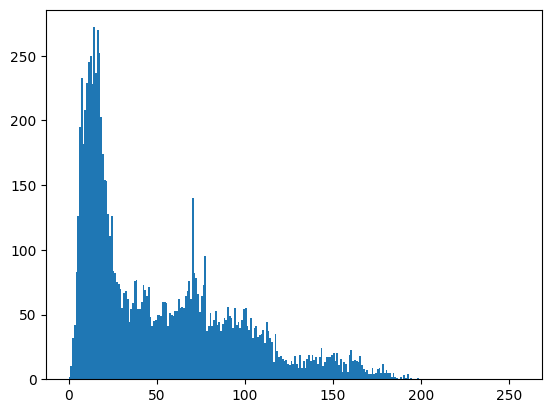

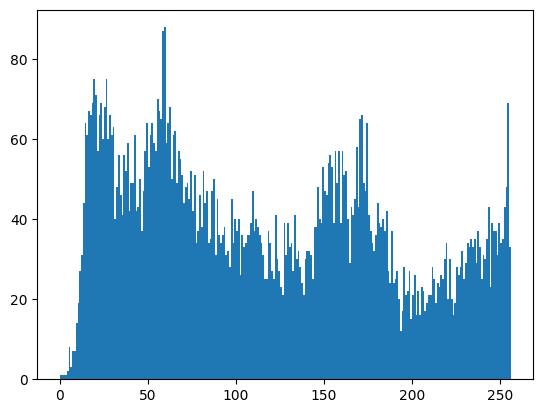

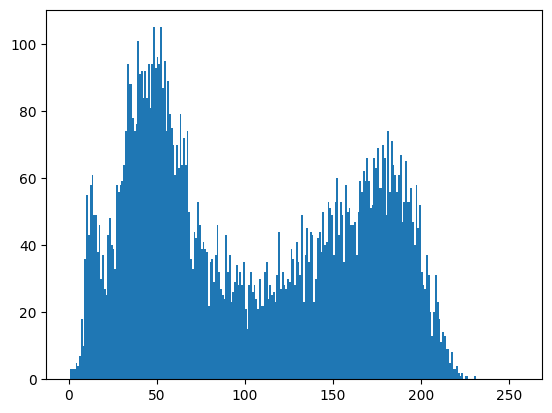

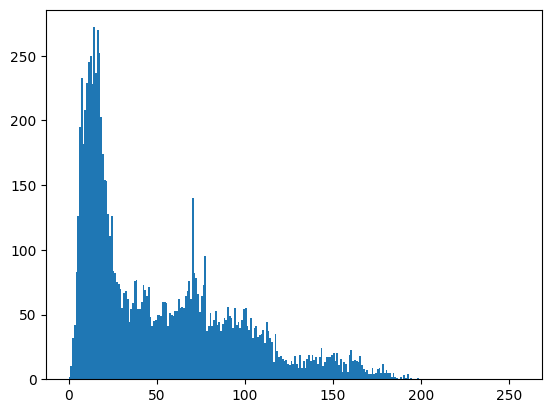

In [25]:
# def histogram_comparison():
folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
           "n02107574-Greater_Swiss_Mountain_dog"]

count = 2
folders = random.sample(folders, count)
collect = {}
for folder in folders:
    random_files = random.sample(os.listdir(f"./Cropped/{folder}"), count)
    collect[folder] = random_files
    count -= 1

# convert image to grayscale   
same_class_grayscale_images = []   
diff_class_grayscale_images = []
for folder, image in collect.items():     
    for img in image:
        path = f"./Cropped/{folder}/{img}"
        loaded_image = cv.imread(path)
        grayscale = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        if list(collect.keys())[0] == folder:
            same_class_grayscale_images.append(grayscale)
        else:
            diff_class_grayscale_images.append(grayscale)
            diff_class_grayscale_images.append(same_class_grayscale_images[0])


# histogram comparison

# same class
for image in same_class_grayscale_images:
    assert image is not None
    plt.hist(image.ravel(), 256, [0, 256])
    plt.show()

# different class               
for image in diff_class_grayscale_images:
    assert image is not None
    plt.hist(image.ravel(), 256, [0, 256])
    plt.show()

# histogram comparison using metrics

# same class

# Euclidean distance
same_ed = np.linalg.norm(same_class_grayscale_images[1] - same_class_grayscale_images[0])

# Manhattan distance
same_md = np.sum(np.abs(same_class_grayscale_images[1] - same_class_grayscale_images[0]))

# Bhattacharyya distance
same_bd = cv.compareHist(same_class_grayscale_images[0].astype(np.float32), same_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)

# Histogram intersection
same_hi = cv.compareHist(same_class_grayscale_images[0].astype(np.float32), same_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_INTERSECT)

# different class

# Euclidean distance
diff_ed = np.linalg.norm(diff_class_grayscale_images[1] - diff_class_grayscale_images[0])

# Manhattan distance
diff_md = np.sum(np.abs(diff_class_grayscale_images[1] - diff_class_grayscale_images[0]))

# Bhattacharyya distance
diff_bd = cv.compareHist(diff_class_grayscale_images[0].astype(np.float32), diff_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)

# Histogram intersection
diff_hi = cv.compareHist(diff_class_grayscale_images[0].astype(np.float32), diff_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_INTERSECT)

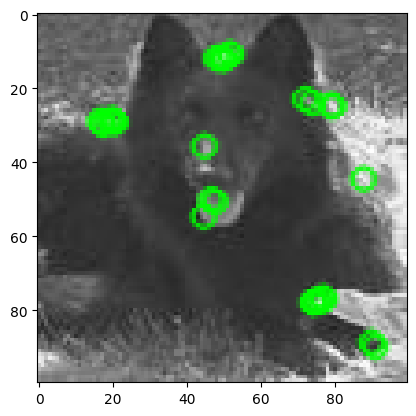

In [6]:
# def image_feature_descriptor():
folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
           "n02107574-Greater_Swiss_Mountain_dog"]

collect = {}
folder = random.sample(folders, 1)[0]
random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 1)
collect[folder] = random_files

img = None
for folder, images in collect.items():
    for img in images:
        path = f"./Cropped/{folder}/{img}"
        loaded_image = cv.imread(path)
        img = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)

orb = cv.ORB_create(edgeThreshold=7, patchSize=30, nlevels=8, fastThreshold=20, scaleFactor=1.2, 
                            WTA_K=2,scoreType=cv.ORB_HARRIS_SCORE, firstLevel=0, nfeatures=30)
kp = orb.detect(img, None)
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [7]:
def dimensionality_reduction():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]

    folders = random.sample(folders, 2)
    files = [f for f in os.listdir(f"./Cropped/{folders[0]}") if os.path.isfile(os.path.join(f"./Cropped/{folders[0]}", f))]
    no_of_images = [len(files)]
    
    files = [f for f in os.listdir(f"./Cropped/{folders[1]}") if os.path.isfile(os.path.join(f"./Cropped/{folders[1]}", f))]
    no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        random_files = random.sample(os.listdir(f"./Cropped/{folder}"), count)
        collect[folder] = random_files
      
    # convert image to grayscale   
    grayscale_images = {}
    count1 = 1
    for folder, image in collect.items():    
        for img in image:
            path = f"./Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale_images[folder] = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
    
    # normalizing the dataset
    class_1_data = []
    class_2_data = []
#     for folder, image in grayscale_images.items():
#         for img in image:
#             assert image is not None
#             histogram, bins = np.histogram(image.flatten(), 256, [0,256])
#             histogram = histogram / histogram.sum().ravel()
#             if folder == folders[0]:
#                 class_1_data.append(histogram)
#             elif folder == folders[1]:
#                 class_2_data.append(histogram)
#     print(count1, count2)            
    for image in grayscale_images[folders[0]]:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        histogram = histogram / histogram.sum().ravel()
        class_1_data.append(histogram)
        
    for image in grayscale_images[folders[1]]:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        histogram = histogram / histogram.sum().ravel()
        class_2_data.append(histogram)
    
#     perfrom PCA dimension reduction
    transformed_data_1 = []
    pca = PCA(n_components = 2) 
    pca.fit(class_1_data)
    transformed_data_1 = pca.transform(class_1_data)
    
    transformed_data_2 = []
    pca = PCA(n_components = 2) 
    pca.fit(class_2_data)
    transformed_data_2 = pca.transform(class_2_data)

    # plotting
    plt.scatter(transformed_data_1[:, 0], transformed_data_1[:, 1], color='r')
    plt.scatter(transformed_data_2[:, 0], transformed_data_2[:, 1], color='b')
    plt.grid(True)
    plt.show()

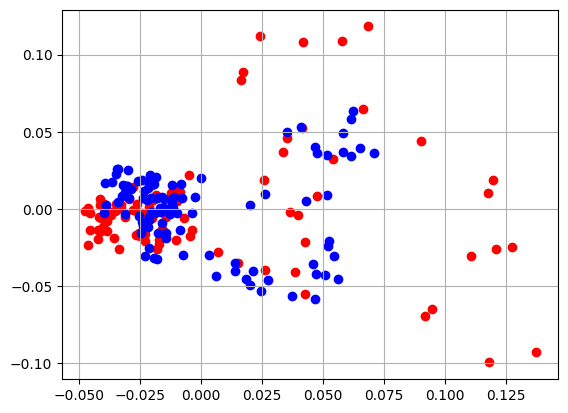

In [8]:
dimensionality_reduction()